# Training neural network to predict ball position in a 3d space

## 1. Fill in the variables
Be carefull with the hyperparameter tuning it can take a long time for large datasets (>5000 rows)

In [37]:
red_ball_location = '../data-5cams/red_ball_all_5cams.csv'
positions_location = '../data-5cams/positions_all_5cams.csv'
amount_of_cams = 5
red_ball_test_location = '../data-5cams/red_ball_coordinates_128px_2024-03-17_19h32m.csv'
positions_test_location = '../data-5cams/positions_xyz_2024-03-17_19h32m.csv'
shape_of_test = "8 motion"
hyper_param_tuning = True
# if you want to add more test trajectories than you will have to add a few more lines of code at the end of the notebook


## 2. Importing Libraries

In [38]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline

In [39]:
X = pd.read_csv(red_ball_location, decimal='.', delimiter=',')
y = pd.read_csv(positions_location, decimal='.', delimiter=',')
X.shape, y.shape

((8506, 10), (8506, 3))

In [ ]:
combined = pd.concat([X, y], axis=1)
print(f'The data has missing values: {combined.isnull().sum().sum()}')
combined.dropna(inplace=True)
print(f'The data has missing values: {combined.isnull().sum().sum()}')

In [ ]:
X = combined.iloc[:, :amount_of_cams*2]
y = combined.iloc[:, amount_of_cams*2:]

## 3. Preprocessing

In [40]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

## 4. Hyperparameter tuning

In [41]:
if hyper_param_tuning:
    pipeline = Pipeline([
        ('mlp', MLPRegressor())
    ])
    param_grid = {
        'mlp__hidden_layer_sizes': [(50,100,50), [50, 50], [100,]],
        'mlp__activation': ['identity', 'tanh', 'relu'],
        'mlp__solver': ['sgd', 'adam'],
        'mlp__alpha': [0.001, 0.01, 0.1],
        'mlp__max_iter': [10000, 20000, 28000],
        'mlp__learning_rate': ['constant', 'adaptive'],
        'mlp__learning_rate_init': [0.001, 0.01, 0.1],
        'mlp__early_stopping': [True],
    }

    random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=100, cv=5, n_jobs=-1, verbose=2, random_state=42)
### 4.1 Training
    random_search.fit(X_scaled, y_scaled)
### 4.2 Best parameters
    print(f'Best parameters: {random_search.best_params_}')
    print(f'Best score: {random_search.best_score_}')
    model = random_search.best_estimator_
else:
    model = MLPRegressor(solver='adam', max_iter=20000, learning_rate_init=0.001, learning_rate='adaptive', hidden_layer_sizes=(50, 100, 50), early_stopping=True, alpha=0.01, activation='tanh')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\xande\venv\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
40 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\xande\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\xande\venv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\xande\venv\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\xande\venv\lib\site-

Best parameters: {'mlp__solver': 'adam', 'mlp__max_iter': 20000, 'mlp__learning_rate_init': 0.001, 'mlp__learning_rate': 'adaptive', 'mlp__hidden_layer_sizes': (50, 100, 50), 'mlp__early_stopping': True, 'mlp__alpha': 0.01, 'mlp__activation': 'tanh'}
Best score: 0.7734523733833137


## 5. Training the model

In [42]:
model.fit(X_scaled, y_scaled)

Pipeline(steps=[('mlp',
                 MLPRegressor(activation='tanh', alpha=0.01,
                              early_stopping=True,
                              hidden_layer_sizes=(50, 100, 50),
                              learning_rate='adaptive', max_iter=20000))])

## 6. Make predictions on new data

### 6.1 Load new data of a new trajectory

In [43]:
X_test = pd.read_csv(red_ball_test_location, decimal='.', delimiter=',')
y_test = pd.read_csv(positions_test_location, decimal='.', delimiter=',')

In [44]:
difference = y_test.shape[0] - X_test.shape[0]
# drop the difference from the front of y, the unity positions will most of the time save 4 rows before the ball actually starts moving, so they have to be dropped
y_test = y_test.iloc[difference:]

### 6.2 Preprocessing
This method is used to prepare the data for the model. It scales the input data and drops the NaN values from the output data.

In [45]:
from utils.data_preperations import prepare_and_scale_test_data
X_scaled_test, y_test = prepare_and_scale_test_data(X_test, y_test, scaler_X, 5)

### 6.3 Make predictions evaluate and visualize
This method is used to make predictions on the test data, then it evaluates the model using the mean squared error, mean absolute error and the r2 score. Finally, it visualizes the predicted and the actual trajectory of the ball in a 3d space.

In [47]:
X_scaled_test.shape, y_test.shape

((1001, 10), (1001, 3))

Mean Squared Error on Test Data Set: 0.48460290364741176
Mean Absolute Error on Test Data Set: 0.542227342649881
R2 Score on Test Data set: 0.5838972848998651


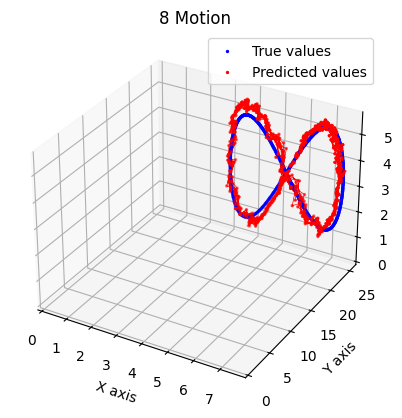

In [48]:
from utils.evaluate import predict_evaluate_plot

y_test_8_pred, mse_8, mae_8, r2_8 = predict_evaluate_plot(X_scaled_test, y_test, model, scaler_y, '8 Motion')